In [2]:
import numpy as np
from numpy import diff
import pandas as pa
import pylab as pl
from scipy.signal import hilbert
from scipy import signal
%matplotlib inline
import matplotlib.pylab as plt
import sqlite3

In [3]:
DATA_CAPTURE_ID = 1736

In [4]:
def GetSensor(use_i,sensor_i):
    sql_s = "SELECT timestamp_ms, value FROM data WHERE data_capture_id={} AND sensor_id={}".format(use_i,sensor_i)
    conn = sqlite3.connect('data/toilet.db')
    cursor = conn.execute(sql_s)
    time_measurements = []
    distance_measurements = []
    for row in cursor:
        time_measurements.append(row[0])
        distance_measurements.append(row[1])
    #endfor
    data_t = (time_measurements,distance_measurements)
    return data_t
#enddef

In [5]:
def cleanSensors(sensor1_t_l,sensor1_y_l,sensor2_t_l,sensor2_y_l):

    # get min / max of time-series
    #sensor1_t_l = data_d[1][0]
    #sensor2_t_l = data_d[2][0]
    #sensor1_y_l = data_d[1][1]
    #sensor2_y_l = data_d[2][1]
    min_t = min(min(sensor1_t_l),min(sensor2_t_l))
    max_t = max(max(sensor1_t_l),max(sensor2_t_l))

    # setup partitions
    step_t = 500
    min_floor_t = int(np.floor(min_t/step_t)*step_t)
    max_ceil_t = int(np.ceil(max_t/step_t)*step_t)
    
    step1_d = {}
    step2_d = {}
    for i in range(min_floor_t,max_ceil_t+step_t,step_t):
        step1_d[i] = []
        step2_d[i] = []
    #endfor

    # step through both and assign values to each partition
    for i in range(len(sensor1_t_l)):
        interval_t = int(np.floor(sensor1_t_l[i]/step_t)*step_t)
        step1_d[interval_t].append(sensor1_y_l[i])
    #endfor
    for i in range(len(sensor2_t_l)):
        interval_t = int(np.floor(sensor2_t_l[i]/step_t)*step_t)
        step2_d[interval_t].append(sensor2_y_l[i])
    #endfor

    # step through each partition and either take averages or set to nan
    clean1_d = {}
    for i in step1_d.keys():
        if(len(step1_d[i]) > 0):
            clean1_d[i] = np.mean(step1_d[i])
    #endfor
    clean1_sz = pa.Series(clean1_d)

    clean2_d = {}
    for i in step2_d.keys():
        if(len(step2_d[i]) > 0):
            clean2_d[i] = np.mean(step2_d[i])
    #endfor
    clean2_sz = pa.Series(clean2_d)
    
    return clean1_sz, clean2_sz

In [6]:
def GetTotalWeight(data_capture_id):
    data_d = {}
    data_d[2] = GetSensor(data_capture_id, 2) # seat scale
    data_d[3] = GetSensor(data_capture_id, 3) # foot scale
    
    #t0 = data_d[2][0][0]
    
    clean1_sz, clean2_sz = cleanSensors(data_d[2][0],data_d[2][1],data_d[3][0],data_d[3][1])
    seatScale_sz = clean1_sz/1000
    footScale_sz = clean2_sz/1000
    sumScale_sz = seatScale_sz  + footScale_sz
    #sumScaleFiltered_sz = pd.Series(signal.medfilt(sumScale_sz, 11))
        
    sumScale_sz.index = (sumScale_sz.index - sumScale_sz.index[0])/1000
    #x_ix = sumScale_sz.index
    return sumScale_sz

In [7]:
def GetRadarSum(data_capture_id):

    data_fn = 'data/data_frames/data_capture_{}/radar_data.txt'.format(data_capture_id)
    data_f = open(data_fn,'rt')
    line_s = data_f.read()
    data_l = eval(line_s)

    # save array of images
    t0_sz = pa.Series(data_l[0]['data'])
    data_d = {}
    for j in range(len(data_l)):
        t = data_l[j]['timestamp_ms']
        j_sz = pa.Series(data_l[j]['data'][0])
        data_d[t] = j_sz
    #endfor
    data_df = pa.DataFrame(data_d)
    
    area_d = {}
    floor_i = 50
    ceil_i = 200
    for i in data_df.columns:
        sq_sz = (data_df[i])**2
        area_d[i] = sum(sq_sz.iloc[floor_i:ceil_i])
    #endfor
    area_sz = pa.Series(area_d)
    area_sz = area_sz / 1e9
    area_sz = area_sz - area_sz.median()
    t0 = data_l[0]['timestamp_ms']
    area_sz.index = (area_sz.index-t0)/1000 #
    
    return area_sz

In [8]:
def frame(data, window_length, hop_length):
    """Convert array into a sequence of successive possibly overlapping frames.
    An n-dimensional array of shape (num_samples, ...) is converted into an
    (n+1)-D array of shape (num_frames, window_length, ...), where each frame
    starts hop_length points after the preceding one.
    
    This is accomplished using stride_tricks, so the original data is not
    copied.  However, there is no zero-padding, so any incomplete frames at the
    end are not included.
    Args:
    data: np.array of dimension N >= 1.
    window_length: Number of samples in each frame.
    hop_length: Advance (in samples) between each window.
    Returns:
    (N+1)-D np.array with as many rows as there are complete frames that can be
    extracted.
    """
    num_samples = data.shape[0]
    num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
    shape = (num_frames, window_length) + data.shape[1:]
    strides = (data.strides[0] * hop_length,) + data.strides
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

In [9]:
def ApplyEnvelope(sz):
    analytic_signal = hilbert(sz)
    env_sz = pa.Series(np.abs(analytic_signal))
    env_sz.index = sz.index
    return env_sz

In [10]:
def GetValuesAboveThreshold(sz, threshold):
    return sz > threshold

In [11]:
def GetValuesBelowThreshold(sz, threshold):
    return sz < threshold

In [12]:
def ApplyMedianFilter(sz, window_size):
    filt_sz = pa.Series(signal.medfilt(sz, window_size))
    filt_sz.index = sz.index
    return filt_sz

In [13]:
def GetStartEndTimesOfBooleanSz(sz):
    ts = sz.index
    start_end_times = []
    
    i = 0
    while i < len(sz):
        if sz.values[i] == True:
            j = i
            while (j < len(sz)-1) and (sz.values[j+1] == True):
                j += 1
            start_end_times.append([ts[i], ts[j]])
            i = j + 1
        else:
            i += 1

    return start_end_times

In [14]:
def GetWeightChange(weight_sz, start_time, end_time):
    start_idx = (pa.Series(weight_sz.index) > start_time).idxmax() - 1
    end_idx = (pa.Series(weight_sz.index) > end_time).idxmax()
    print("Weight at start time: {}".format(weight_sz.iloc[start_idx]))
    print("Weight at end time: {}".format(weight_sz.iloc[end_idx]))
    return weight_sz.iloc[start_idx] - weight_sz.iloc[end_idx]

In [15]:
def RightExtendBooleanTrueValues(sz, extension_time):
    temp_sz = sz.copy()
    i = 1
    while i < len(temp_sz):
        if((temp_sz.values[i-1] == True) and (temp_sz.values[i] == False)):
            extension_end_time = temp_sz.index[i] + extension_time
            while (i < len(temp_sz)) and (temp_sz.index[i] < extension_end_time):
                temp_sz.values[i] = True
                i += 1
        i += 1
    return temp_sz

In [16]:
def LeftExtendBooleanTrueValues(sz, extension_time):
    temp_sz = sz.copy()
    i = len(temp_sz) - 2
    while i >= 0:
        if((temp_sz.values[i] == False) and (temp_sz.values[i+1] == True)):
            extension_end_time = temp_sz.index[i] - extension_time
            while (i >= 0) and (temp_sz.index[i] > extension_end_time):
                temp_sz.values[i] = True
                i -= 1
        i -= 1
    return temp_sz

In [17]:
# Get toilet seat weight sensor data and sampling rate
time_ms, ts_weight_g = GetSensor(DATA_CAPTURE_ID,2) # seat scale
ts_total_time_s = float((time_ms[len(time_ms) -1] - time_ms[0])/1000)
ts_num_samples = len(time_ms)
ts_frequency_sampling = float(ts_num_samples / ts_total_time_s)

In [18]:
# Calculate derivative of toilet seat weight sensor data
ts_weight_g_sz = pa.Series(ts_weight_g)
ts_weight_g_derivative = diff(ts_weight_g_sz.to_numpy())/diff(ts_weight_g_sz.index)
ts_weight_g_derivative = np.append(ts_weight_g_derivative, 0)

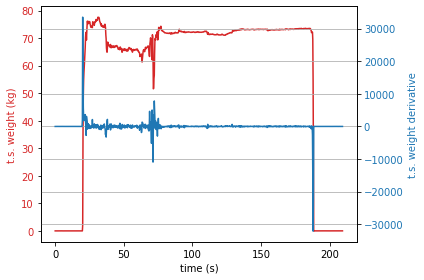

In [20]:
# Plot the derivative of the toilet seat weight sensor data, to get a visual
ts_weight_x = ts_weight_g_sz.index*(float(1/ts_frequency_sampling))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('t.s. weight (kg)', color=color)
ax1.plot(ts_weight_x, ts_weight_g_sz/1000, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('t.s. weight derivative', color=color)  
ax2.plot(ts_weight_x, ts_weight_g_derivative)
ax2.tick_params(axis='y', labelcolor=color)
plt.grid()

fig.tight_layout()
plt.show()

In [21]:
# Break toilet seat derivative into 1 second windows, and calculate the energy in each window

WINDOW_SECONDS = 1
HOP_SECONDS = 1     # hop is overlap between windows
ts_window_length = int(round(WINDOW_SECONDS * ts_frequency_sampling))
ts_hop_length = int(round(HOP_SECONDS * ts_frequency_sampling))

ts_weight_frames = frame(ts_weight_g_derivative, ts_window_length, ts_hop_length)
ts_weight_energy = np.sum(ts_weight_frames*ts_weight_frames, 1)
ts_weight_energy_sz = pa.Series(ts_weight_energy)
ts_frame_n = ts_weight_frames.shape[0]
ts_weight_energy_sz.index = np.array(range(ts_frame_n))*float(ts_window_length/ts_frequency_sampling)

# Smooth the result 
ts_weight_energy_filt_sz = ApplyMedianFilter(ts_weight_energy_sz, 5)

In [22]:
# Find out when user is stable on toilet seat by finding toilet seat derivative energy values below a threshhold

ts_weight_is_stable = GetValuesBelowThreshold(ts_weight_energy_filt_sz, 5e5)

In [23]:
# Find out when the user is sitting on the toilet seat by finding toilet seat weight values above a threshold

ts_weight_frames = frame(ts_weight_g_sz.to_numpy()/1000,ts_window_length,ts_hop_length)
ts_weight_filt = np.median(ts_weight_frames, 1)
ts_weight_sz = pa.Series(ts_weight_filt)
frame_n = ts_weight_frames.shape[0]
ts_weight_sz.index = np.array(range(ts_frame_n))*float(ts_window_length/ts_frequency_sampling)
ts_weight_above_3kg = GetValuesAboveThreshold(ts_weight_sz, 3)

In [24]:
# Find start time and end times of stable weight readings on the toilet seat

start_end_times = GetStartEndTimesOfBooleanSz(ts_weight_is_stable & ts_weight_above_3kg)

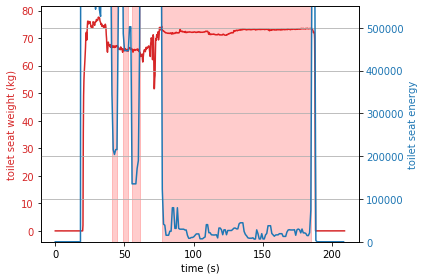

In [25]:
# Plot the toilet seat derivative energy to get a visual.  
# When the energy of the derivative is relatively low, the weight is stable 
# (ie. user is not moving around, and weight measurement is likely to be accurate)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('toilet seat weight (kg)', color=color)
ax1.plot(ts_weight_x, ts_weight_g_sz/1000, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('toilet seat energy', color=color)  
ax2.plot(ts_weight_energy_filt_sz.index, ts_weight_energy_filt_sz)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,5.5e5)
plt.grid()

for start_end in start_end_times:
    plt.axvspan(start_end[0], start_end[1], alpha=0.2, color='red')

fig.tight_layout()
plt.show()

In [24]:
# Use the first start time and the last end time to calculate the total weight loss 
# of the user on the toilet seat

start_time = start_end_times[0][0]+1
end_time = start_end_times[len(start_end_times)-1][1]-1

total_weight_sz = GetTotalWeight(DATA_CAPTURE_ID)
total_weight_filt_sz = ApplyMedianFilter(total_weight_sz, 23)

print("Estimated start time: {}".format(start_time))
print("Estimated end time: {}".format(end_time))
total_weight_loss = GetWeightChange(total_weight_filt_sz, start_time, end_time)
print("Estimated total weight loss: {} g".format(total_weight_loss*1000))


Estimated start time: 41.98130434782609
Estimated end time: 183.87121739130436
Weight at start time: 94.68599999999999
Weight at end time: 94.32799999999999
Estimated total weight loss: 358.0000000000041 g


In [25]:
# Defecation Weight Loss
radar_sum_sz = GetRadarSum(DATA_CAPTURE_ID)
radar_sum_env_sz = ApplyEnvelope(radar_sum_sz)
radar_sum_env_filt_sz = ApplyMedianFilter(radar_sum_env_sz, 21)
radar_sum_filt_sz = ApplyMedianFilter(radar_sum_sz, 11)
radar_vals_above_threshold = GetValuesAboveThreshold(radar_sum_filt_sz, .1)
radar_vals_above_threshold = RightExtendBooleanTrueValues(radar_vals_above_threshold, 2)
radar_vals_above_threshold = LeftExtendBooleanTrueValues(radar_vals_above_threshold, 2)
defecation_start_end_times = GetStartEndTimesOfBooleanSz(radar_vals_above_threshold)

defecation_weight_loss = 0
for start_end in defecation_start_end_times:
    print("Estimated start time of defecation: {}".format(start_end[0]))
    print("Estimated end time of defecation: {}".format(start_end[1]))
    weight_loss = GetWeightChange(total_weight_filt_sz, start_end[0], start_end[1])
    if weight_loss > 0:
        defecation_weight_loss += weight_loss
    print("Estimated defecation weight loss between start and end time: {} g".format(weight_loss*1000))
    
print("Estimated defecation weight loss: {} g".format(defecation_weight_loss*1000))


Estimated start time of defecation: 115.913
Estimated end time of defecation: 126.845
Weight at start time: 94.51533333333333
Weight at end time: 94.357
Estimated defecation weight loss between start and end time: 158.33333333333144 g
Estimated defecation weight loss: 158.33333333333144 g


Text(0, 0.5, 'radar sum')

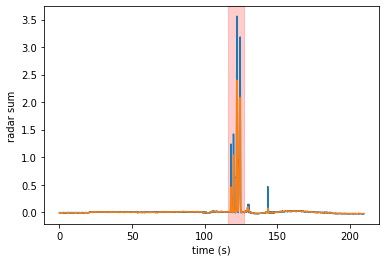

In [26]:
plt.plot(radar_sum_sz.index, radar_sum_sz)
plt.plot(radar_sum_filt_sz.index, radar_sum_filt_sz)
for start_end in defecation_start_end_times:
    plt.axvspan(start_end[0], start_end[1], alpha=0.2, color='red')
plt.xlabel('time (s)')
plt.ylabel('radar sum')

In [27]:
print("Estimated urination weight loss: {}g".format((total_weight_loss - defecation_weight_loss)*1000))

Estimated urination weight loss: 199.66666666667265g


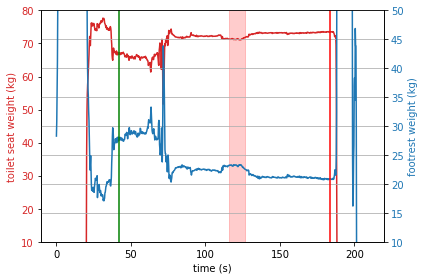

In [28]:
# Plot footrest and toilet seat weights over time


time_ms, fr_weight_g = GetSensor(DATA_CAPTURE_ID,3) # footrest
fr_total_time_s = float((time_ms[len(time_ms) -1] - time_ms[0])/1000)
fr_num_samples = len(time_ms)
fr_frequency_sampling = float(fr_num_samples / fr_total_time_s)
fr_weight_g_sz = pa.Series(fr_weight_g)
fr_weight_x = fr_weight_g_sz.index*(float(1/fr_frequency_sampling))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('toilet seat weight (kg)', color=color)
ax1.set_ylim(10,80)
ax1.plot(ts_weight_x, ts_weight_g_sz/1000, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('footrest weight (kg)', color=color)  
ax2.set_ylim(10,50)
ax2.plot(fr_weight_x, fr_weight_g_sz/1000, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.grid()

plt.axvline(start_time, color='g')
plt.axvline(end_time, color='r')

for start_end in defecation_start_end_times:
    plt.axvspan(start_end[0], start_end[1], alpha=0.2, color='red')

fig.tight_layout()  
plt.show()

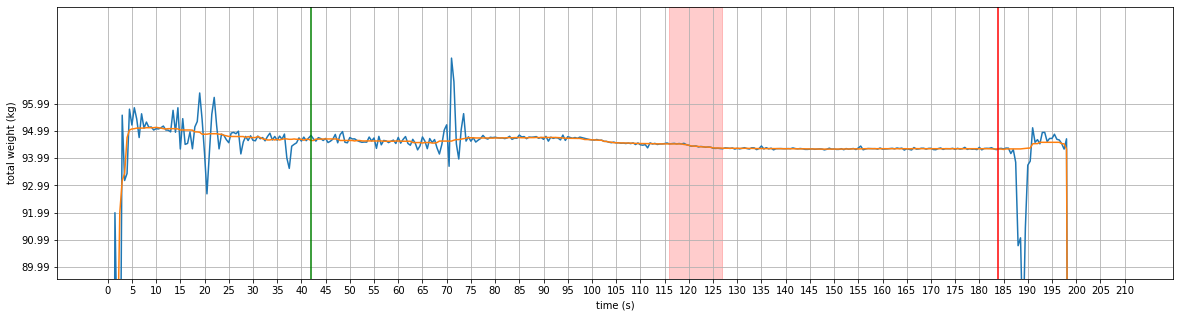

In [29]:
# Plot total weight over time

plt.figure(figsize=(20,5))
plt.plot(total_weight_sz.index, total_weight_sz)
plt.plot(total_weight_filt_sz.index, total_weight_filt_sz)
plt.axvline(start_time, color='g')
plt.axvline(end_time, color='r')
for start_end in defecation_start_end_times:
    plt.axvspan(start_end[0], start_end[1], alpha=0.2, color='red')
plt.xticks(np.arange(min(total_weight_filt_sz.index), max(total_weight_filt_sz.index)+1, 5.0))
plt.yticks(np.arange(min(total_weight_filt_sz), 95+1, 1))
plt.ylim(total_weight_filt_sz.median()-5, total_weight_filt_sz.median()+5)
plt.xlabel('time (s)')
plt.ylabel('total weight (kg)')
plt.grid()
